DOGE static vs dynamic

In [87]:
%pip install junix

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for junix: filename=junix-0.1.5-py3-none-any.whl size=3595 sha256=987a1641495901beb50c727e9b62f6c305224219a46fe3ccc53cb90cd445514c
  Stored in directory: c:\users\natha\appdata\local\pip\cache\wheels\68\ef\95\501e99c17ccf609e930a935d6cf8b0504d02a987343b7e4c6b
Successfully built junix
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
from numpy.ma.core import resize
from scipy.stats import t
from datetime import datetime, timedelta
import time
import matplotlib.pyplot as plt
import pyextremes as pyx
from arch import arch_model
from statsmodels.stats.diagnostic import (acorr_ljungbox)
import statsmodels.api as sm

c:\Users\natha\anaconda3\Lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.6 when it was built against 1.14.5, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [88]:
def get_doge_data():
    doge_yf = yf.download("DOGE-USD", start="2014-01-01", interval="1d")
    print(doge_yf)

    doge_data = pd.read_csv("doge_data.csv")
    doge_data['Date'] = pd.to_datetime(doge_data['Timestamp'])
    print(doge_data)

    result_dataset = pd.DataFrame()
    for i in range(0, len(doge_data)):
        # print(doge_data.iloc[i])
        if (doge_data.iloc[i]['Date'] < pd.to_datetime('2017-11-09 00:00:00.000')):
            new_entry = {'Date': doge_data.iloc[i]['Date'], 'Price': doge_data.iloc[i]['Price']}
            result_dataset = pd.concat([result_dataset, pd.DataFrame([new_entry])], ignore_index=True)

    doge_yf = doge_yf.reset_index()

    # Now select only the 'Date' and 'Close' columns
    doge_date_close = doge_yf[['Date', 'Close']]
    doge_date_close.columns = doge_date_close.columns.droplevel(level=1)
    print(doge_date_close.head())

    for i in range(0, len(doge_date_close)):
        new_entry = {'Date': doge_date_close.iloc[i]['Date'], 'Price': doge_date_close.iloc[i]['Close']}
        # print(new_entry)
        result_dataset = pd.concat([result_dataset, pd.DataFrame([new_entry])], ignore_index=True)

    current = pd.to_datetime('2013-12-15 00:00:00.00')
    cnt = 0
    print(len(result_dataset))
    for i in range(0, len(result_dataset)):
        if (result_dataset.iloc[i]['Date'] != current):
            cnt += 1
            i -= 1
            print(current)
        current = current + pd.Timedelta(days=1)
    print(cnt)
    result_dataset.to_csv('doge_daily_data.csv', index=False)
    print(result_dataset)

#get_doge_data()

### EVT-Based VaR & ES Estimation with Threshold Diagnostics

This section prepares Dogecoin daily return data and defines key functions for estimating tail risk using **Extreme Value Theory (EVT)** via the **Peaks Over Threshold (POT)** method.

---

#### Data Preparation

- Loads daily Dogecoin prices from `doge_daily_data.csv`.
- Plots the price time series.
- Computes and plots **log returns**, which are used as input to EVT models.

---

#### Threshold Selection Tools

- **`hill_estimator(data, k)`**  
  Estimates the tail index `Î¾` using the **Hill estimator** for the top `k` order statistics.

- **`pickands_estimator(data, k)`**  
  Computes the **Pickands estimator** for `Î¾`, using log-ratios of spacings in the top order statistics.

- **`threshold_picking(data0)`**  
  Visual tool for threshold selection:
  - Uses the **Mean Residual Life (MRL)** plot to identify linear regions.
  - Plots **Hill** and **Pickands** estimates vs. `k` to assess tail stability.
  - Adds a **parameter stability plot** to assess robustness of GPD shape and scale estimates over threshold choices.
  - outputs sorted data

---

#### EVT Tail Fitting and Risk Metrics

- **`modeling(data0, u)`**  
  Fits a **Generalized Pareto Distribution (GPD)** to the exceedances over threshold `u`:
  - Applies POT to the **left tail** (i.e., large losses),
  - Returns GPD parameters: shape `Î¾` and scale `Ïƒ`.

- **`prediction(params, data, u, level)`**  
  Calculates **Value at Risk (VaR)** and **Expected Shortfall (ES)** at confidence level `Î±`:
  - Uses analytical formulae based on the GPD,
  - Returns **VaR and ES values**


Date
2013-12-17   -0.940447
2013-12-18    0.204748
2013-12-19    0.573473
2013-12-20    0.733068
2013-12-21   -0.814607
Name: Price, dtype: float64
Date
2019-09-12    0.010780
2019-09-13    0.000412
2019-09-14    0.006164
2019-09-15    0.007754
2019-09-16   -0.002035
Name: Price, dtype: float64


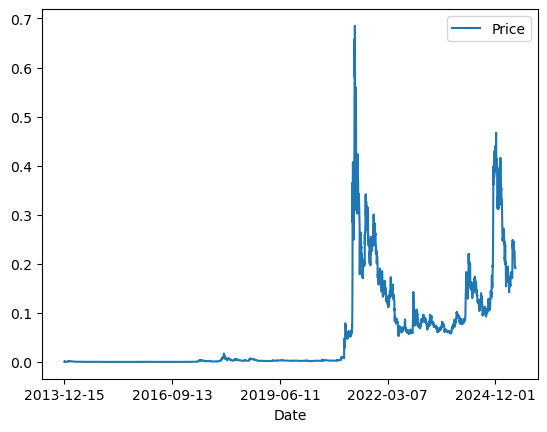

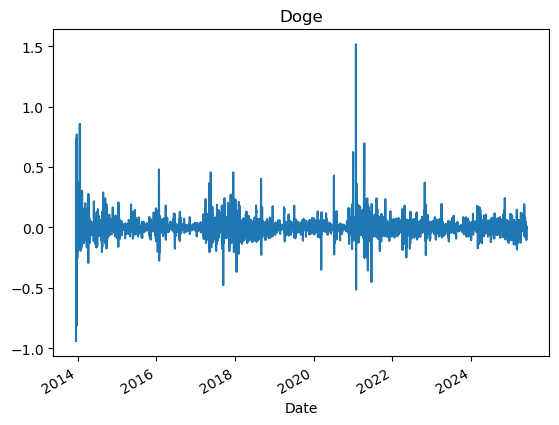

In [4]:
# functions

doge_data = pd.read_csv("../data/doge_daily_data.csv")
doge_data.set_index("Date", inplace=True)
doge_data.plot(label="Doge Price")
plt.legend()

full_data = np.log(doge_data / doge_data.shift(1)).dropna()
full_data = full_data['Price']
full_data.index = pd.to_datetime(full_data.index)
split = len(full_data) // 2
log_doge_returns = full_data.iloc[:split]
backtest_data = full_data.iloc[split:]
print(log_doge_returns.head())
print(backtest_data.head())
plt.figure()
full_data.plot()
plt.title("Doge")

def hill_estimator(data, k):
    log_data = np.log(data[:k])
    return (1/k) * np.sum(log_data) - np.log(data[k])

def pickands_estimator(data, k):
    if 4*k >= len(data):
        return np.nan
    return 1/np.log(2) * np.log((data[k] - data[2*k])/(data[2*k] - data[4*k]))

def threshold_picking(data0):
    data = -data0[data0 < 0]

    fig, axes = plt.subplots(1, 3, figsize=(18,5))
    plt.subplots_adjust(wspace=0.3)

    pyx.plot_mean_residual_life(data, ax=axes[0])
    axes[0].set_title("Mean Residual Life Plot")

    # Mean residual life plot plots average excess value over given threshold for a series of thresholds.
    # The idea is that the mean residual life plot should be approximately linear above a threshold for    
    # which the Generalized Pareto Distribution model is valid.

    datas = np.sort(data)[::-1]
    k_values = range(4, len(datas)//2)
    hill_estimates = [hill_estimator(datas, k) for k in k_values]
    axes[1].plot(k_values, hill_estimates, 'b-')
    axes[1].set_xlabel("k_values")
    axes[1].set_ylabel("hill estimates")
    axes[1].set_title("Hill Plot")

    pickands_estimates = [pickands_estimator(datas, k) for k in k_values]
    axes[2].plot(k_values, pickands_estimates, 'r-', label="Pickands' ξ")
    axes[2].set_xlabel("k_values")
    axes[2].set_ylabel("Pickands Estimates")
    axes[2].set_title("Pickands' Plot")
    axes[2].legend()

    # Parameter stability plot shows how shape and modified scale parameters of the Generalized
    # Pareto Distribution change over a range of threshold values. The idea is that these parameters
    # should be stable (vary by small amount) within a range of valid thresholds.

    pyx.plot_parameter_stability(data0, thresholds=np.linspace(0.01, 0.25, 100))
    plt.title("Parameter stability plots", pad=120)
    plt.show()
    
    return datas

def modeling(data0, u):
    data = -data0[data0 < 0]
    model = pyx.EVA(data)
    model.get_extremes(method="POT", threshold=u)
    model.fit_model(distribution="genpareto")
    print(model.model)
    model.plot_diagnostic()

    params = model.model.fit_parameters
    print(params)
    xi = params['c']
    sig = params['scale']
    return xi, sig

def prediction(params, data, u, level):
    xi = params[0]
    sig = params[1]
    data = -data
    p = level
    n_total = len(data)
    n_exceed = len([i for i in data if i > u])
    F_u = n_exceed / n_total # probability of exceeding the threshold u
    print("Violation ratio: ", F_u)
    p_u = F_u / p
    VaR = u + (sig / xi) * (p_u ** xi - 1)            
    ES = ES = (VaR + (sig - xi * u)/xi) / (1 - xi)
    return -VaR, -ES

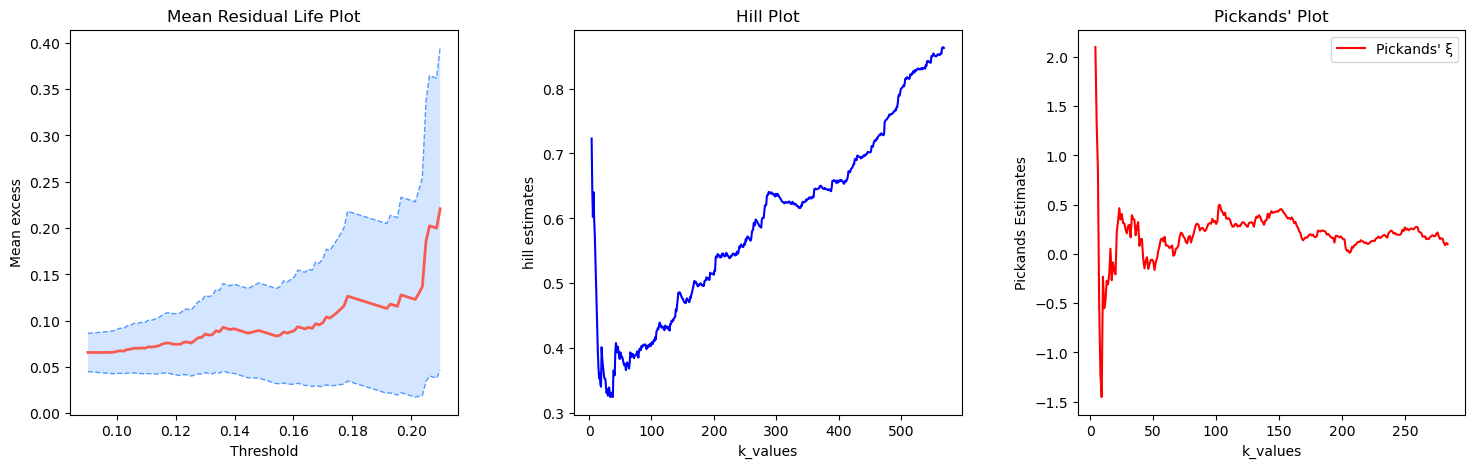

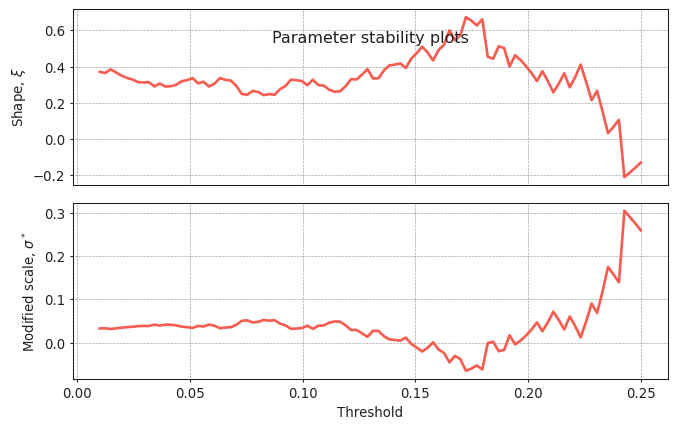

In [128]:
sorted_static_doge = threshold_picking(log_doge_returns)

(<Axes: ylabel='Shape, $\\xi$'>,
 <Axes: ylabel='Modified scale, $\\sigma^*$'>,
 <Axes: ylabel='Return value'>,
 <Axes: xlabel='Threshold', ylabel='AIC Score'>)

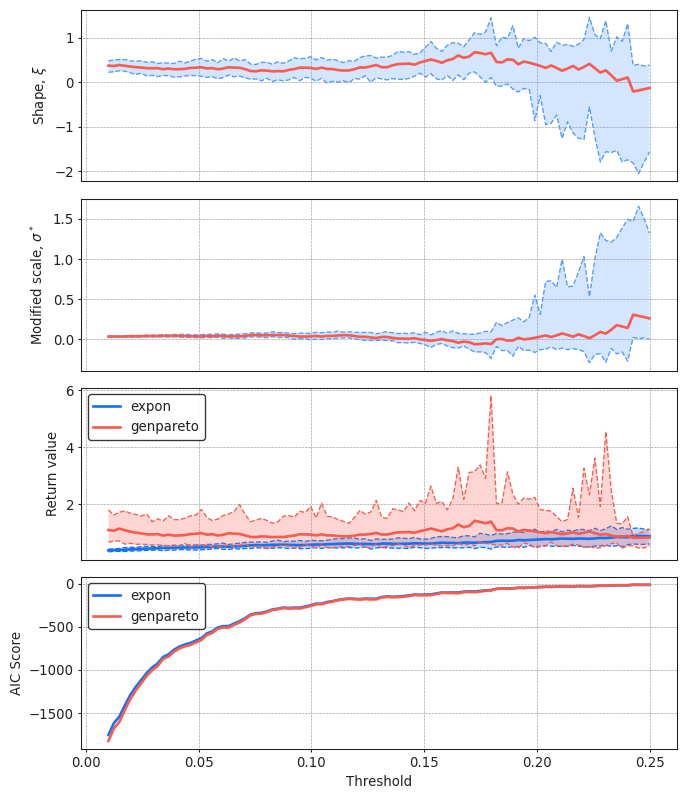

In [129]:
pyx.plot_threshold_stability(log_doge_returns, return_period=10, alpha=0.95, thresholds=np.linspace(0.01, 0.25, 100))
#u = 0.02

# pyextremes provides a convenience function to put all of the above together. It also adds an
# additional plot - AIC curve indicating relative model performance. The AIC curve should not
# be used as a threshold selection tool because it will always have the same logarithmic shape.
# Instead, it should guide the user as to which model (e.g. GEVD or Exponential) should be preferred
# for a given threshold.
# lower AIC better -> GEV



| Method   | Recommended $k$ | Approx. Threshold |
| -------- | --------------- | ----------------- |
| MRL      | â€”               | 0.10â€“0.125        |
| Hill     | 80â€“150         |                   |
| Pickands | 150â€“250         |                   |

pick k = 150 -> threshold 0.10

from threshold stability plot, stable for threshold = 0.10 (0.175 after splitting datasets)

### Static EVT Threshold Selection and Model Fitting

This block performs threshold selection and EVT modeling on **log returns of Dogecoin** using a static (non-GARCH) approach.

---

#### Threshold Selection

```python
u_static_doge = sorted_static_doge[150]


0.08521905306938624
              MLE model              
-------------------------------------
free parameters: c=0.316, scale=0.045
fixed parameters: floc=0.085         
AIC: -405.255                        
loglikelihood: 204.681               
return value cache size: 0           
fit parameter cache size: 0          
-------------------------------------
{'c': 0.3157602852847717, 'scale': 0.04454563670974765}


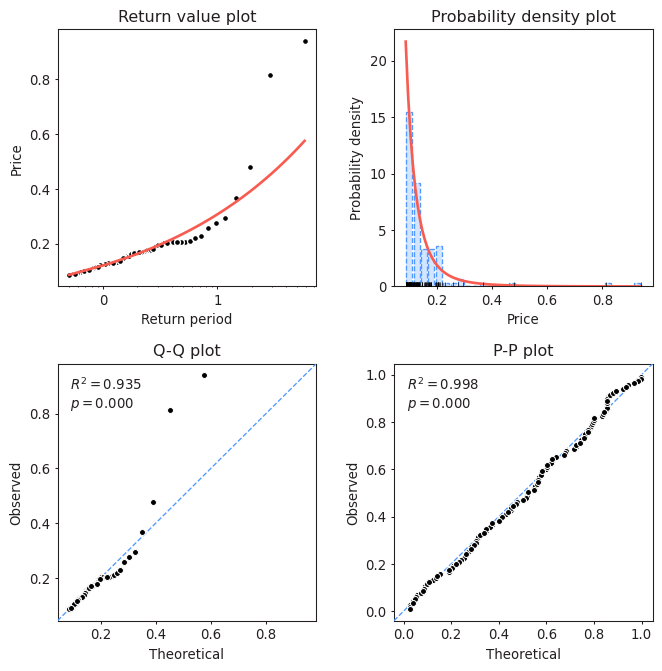

In [108]:
u_static_doge = sorted_static_doge[130]
print(u_static_doge)
params_static_doge = modeling(log_doge_returns, u_static_doge)

### Static EVT-Based VaR and ES Estimation

This step computes **Value at Risk (VaR)** and **Expected Shortfall (ES)** at the **1% level** using the parameters from the static EVT model.



In [109]:
VaR_static_doge, ES_static_doge = prediction(params_static_doge, log_doge_returns, u_static_doge, level=0.01)
print(f"Static EVT 1% VaR: {-VaR_static_doge:.4f}")
print(f"Static EVT 1% ES : {-ES_static_doge:.4f}")


Violation ratio:  0.0621414913957935
Static EVT 1% VaR: 0.1953
Static EVT 1% ES : 0.3671


### Dynamic approach

1. Fit GARCH(1,1) Model
2. Residual standardization
3. Ljung box test (on residuals and squared residuals)
4. ACF plot of squared residuals

c:\Users\natha\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.006237. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      5,   Func. Count:     43,   Neg. LLF: -3066.102562215171
Iteration:     10,   Func. Count:     72,   Neg. LLF: -3156.932873645132
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3156.932873645132
            Iterations: 11
            Function evaluations: 76
            Gradient evaluations: 11
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Price   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                3156.93
Distribution:                  Normal   AIC:                          -6305.87
Method:            Maximum Likelihood   BIC:                          -6283.28
                                        No. Observations:                 2092
Date:                Sun, Jun 08 2025   Df Residuals:                     2091
Time:       

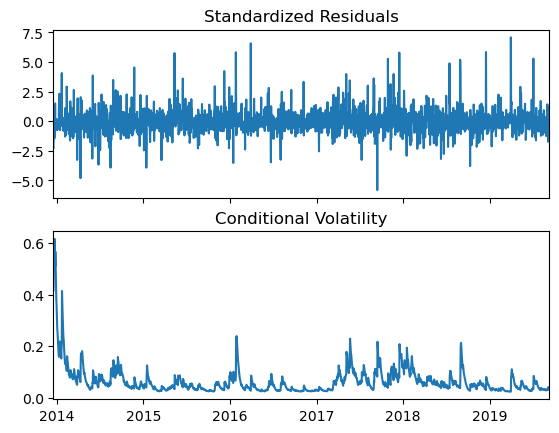

Ljung-Box test on residuals:
    lb_stat  lb_pvalue
1  0.589405   0.442649
Ljung-Box test on squared residuals:
    lb_stat  lb_pvalue
1  2.381921   0.122746
Model is adequate (no remaining ARCH effects at 5% level).


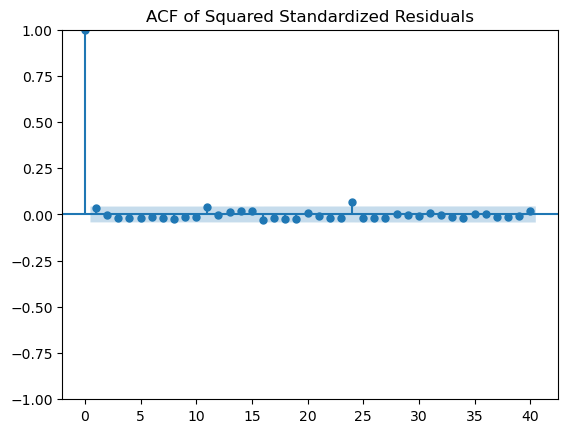

In [110]:
# Two-step process: Fit GARCH(1,1) model, use EVT
doge_model = arch_model(log_doge_returns, vol='Garch', p=1, q=1, mean="Constant") # removed * 10
results = doge_model.fit(update_freq = 5)
print(results.summary())
results.plot()
plt.show()
standardized_resid = results.resid / results.conditional_volatility

# Ljung-Box test (lag 1 as example)
ljung_box = acorr_ljungbox(standardized_resid, lags=1, return_df=True)
print("Ljung-Box test on residuals:")
print(ljung_box)

squared_resid = standardized_resid**2
lb_test_squared = acorr_ljungbox(squared_resid, lags=1, return_df=True)
print("Ljung-Box test on squared residuals:")
print(lb_test_squared)

if lb_test_squared["lb_pvalue"].iloc[0] > 0.05:
    print("Model is adequate (no remaining ARCH effects at 5% level).")
else:
    print("Model is inadequate (try EGARCH or higher-order GARCH).")

# Step 3: Plot ACF
sm.graphics.tsa.plot_acf(squared_resid, lags=40)
plt.title('ACF of Squared Standardized Residuals')
plt.show()

shock at around 2021

check the time series notes on ACF to access the garch (look into 25 lag)

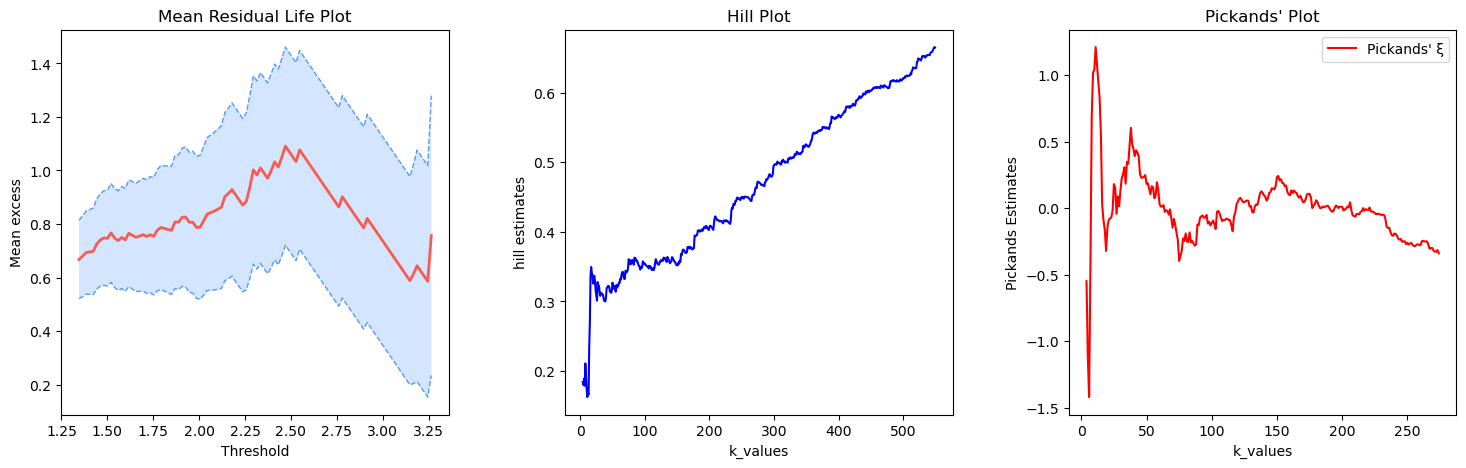

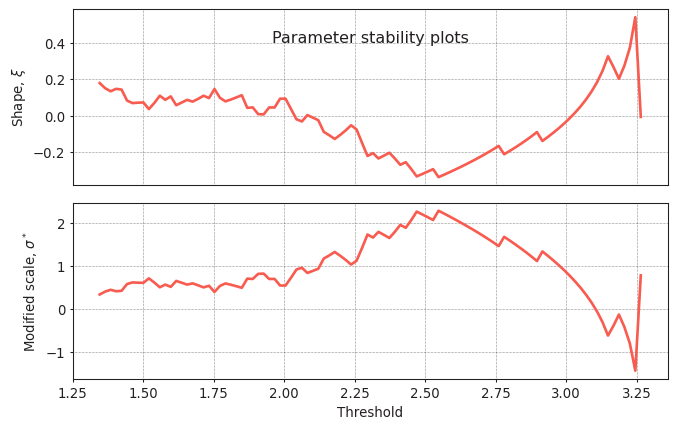

1.3629648026675423


In [111]:
sorted_dynamic_doge = threshold_picking(standardized_resid)
print(sorted_dynamic_doge[105])

(<Axes: ylabel='Shape, $\\xi$'>,
 <Axes: ylabel='Modified scale, $\\sigma^*$'>,
 <Axes: ylabel='Return value'>,
 <Axes: xlabel='Threshold', ylabel='AIC Score'>)

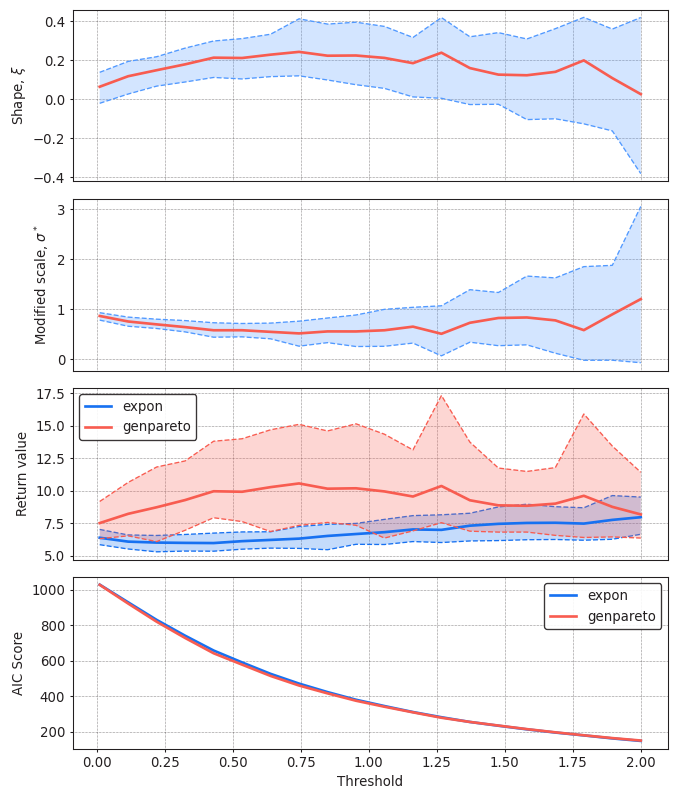

In [112]:
pyx.plot_threshold_stability(standardized_resid, return_period=10, alpha=0.95, thresholds=np.linspace(0.01, 2.0, 20))

| Method   | Recommended $k$ | Approx. Threshold |
| -------- | --------------- | ----------------- |
| MRL      | â€”               | 1.5-1.8        |
| Hill     | 90â€“150         |                   |
| Pickands | 90â€“120         |                   |

pick k = 120 -> threshold 1.3629648026675423

from threshold stability plot, stable for threshold = 1.3629648026675423

threshold for dynamic: 1.3629648026675423
              MLE model              
-------------------------------------
free parameters: c=0.146, scale=0.616
fixed parameters: floc=1.363         
AIC: 132.467                         
loglikelihood: -64.170               
return value cache size: 0           
fit parameter cache size: 0          
-------------------------------------
{'c': 0.14560052159547332, 'scale': 0.6162632829351778}


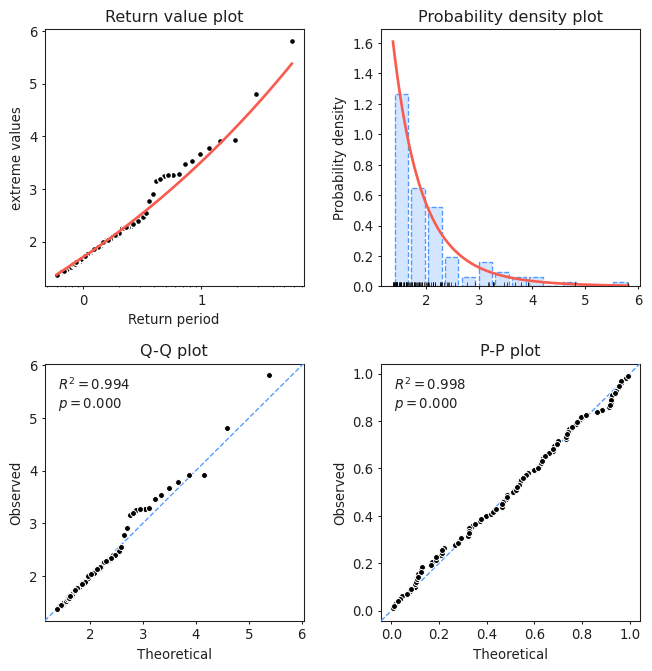

In [113]:
u_dynamic_doge = sorted_dynamic_doge[105]
#u_dynamic_doge = np.searchsorted(sorted_dynamic_doge, 2.25, side="left")
print(f"threshold for dynamic: {u_dynamic_doge}")
params_dynamic_doge = modeling(standardized_resid, u_dynamic_doge)

In [114]:
VaR_dynamic_doge, ES_dynamic_doge = prediction(params_dynamic_doge, standardized_resid, u_dynamic_doge, 0.01)
VaR_return = VaR_dynamic_doge * results.conditional_volatility

# Print selected thresholds
print("\n Thresholds Used:")
print(f"Static EVT Threshold (u_static_doge):  {u_static_doge:.4f}")
print(f"Dynamic EVT Threshold (u_dynamic_doge): {u_dynamic_doge:.4f}")

# Print dynamic EVT results
print("\n Dynamic EVT 1% VaR (on return scale):")
print(VaR_return.describe())

print(f"\n Dynamic EVT 1% Expected Shortfall (ES): {ES_dynamic_doge:.4f}")

# Print static EVT results
print(f"\n Static EVT Results (based on raw log returns):")
print(f"Static EVT 1% VaR: {VaR_static_doge:.4f}")
print(f"Static EVT 1% ES : {ES_static_doge:.4f}")

Violation ratio:  0.05019120458891013

 Thresholds Used:
Static EVT Threshold (u_static_doge):  0.0852
Dynamic EVT Threshold (u_dynamic_doge): 1.3630

 Dynamic EVT 1% VaR (on return scale):
count    2092.000000
mean       -0.160193
std         0.135000
min        -1.528176
25%        -0.189217
50%        -0.123318
75%        -0.084122
max        -0.059366
Name: cond_vol, dtype: float64

 Dynamic EVT 1% Expected Shortfall (ES): -6.2655

 Static EVT Results (based on raw log returns):
Static EVT 1% VaR: -0.1953
Static EVT 1% ES : -0.3671


Unconditional, Conditional coverage test

-2.4836226857490513


<Axes: xlabel='Date'>

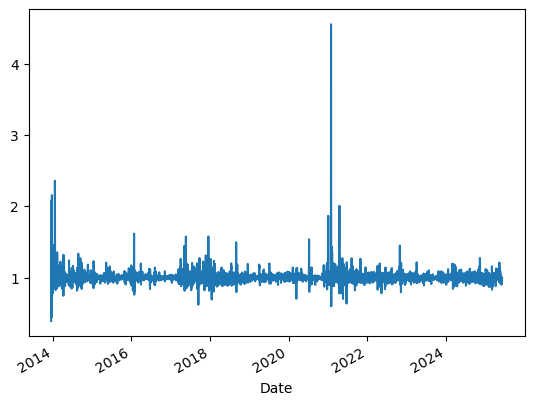

In [115]:
from scipy.stats import chi2

def unconditional_coverage_test(actual_returns, var_forecast, alpha=0.05):
    violations = (actual_returns < var_forecast).astype(int) #indicator function
    V = np.sum(violations) # No. of violations
    p = len(actual_returns) # Total observations
    k = V/p

    LR_statistic = -2 * np.log(k**V*(1-k)**(p-V)/(1-alpha)**V*alpha**(p-V))

    p_value = 1 - chi2.cdf(LR_statistic, df=1)

    reject_null = p_value < 0.05

    return LR_statistic, p_value, reject_null

def conditional_coverage_test(actual_returns, var_forecast, alpha=0.05):
    # Unconditional Coverage (UC) Test
    actual_returns = np.asarray(actual_returns).flatten()
    var_forecast = np.asarray(var_forecast).flatten()
    
    min_length = min(len(actual_returns), len(var_forecast))
    actual_returns = actual_returns[:min_length]
    var_forecast = var_forecast[:min_length]

    violations = (actual_returns < var_forecast).astype(int) 
    #print(violations.head())
    n = len(violations)
    V = np.sum(violations)
    p_uc = V / n
    #print(actual_returns.head(), var_forecast, p_uc)
    LR_uc = -2 * np.log((alpha**V * (1 - alpha)**(n - V))) + 2 * np.log((p_uc**V * (1 - p_uc)**(n - V)))
    p_value_uc = 1 - chi2.cdf(LR_uc, df=1)
    
    # Independence (IND) Test
    # Count transitions: n_ij = transitions from state i to j (0=no violation, 1=violation)
    n00, n01, n10, n11 = 0, 0, 0, 0
    for t in range(1, n):
        prev, curr = violations[t-1], violations[t]
        if prev == 0 and curr == 0: n00 += 1
        elif prev == 0 and curr == 1: n01 += 1
        elif prev == 1 and curr == 0: n10 += 1
        elif prev == 1 and curr == 1: n11 += 1
    
    # Transition probabilities under H0 (independence)
    p01 = n01 / (n00 + n01) if (n00 + n01) > 0 else 0
    p11 = n11 / (n10 + n11) if (n10 + n11) > 0 else 0
    p_ind = (n01 + n11) / (n00 + n01 + n10 + n11)  # Marginal violation probability
    
    # Likelihoods
    L_ind = (1 - p_ind)**(n00 + n10) * p_ind**(n01 + n11)  # Independence
    L_actual = (1 - p01)**n00 * p01**n01 * (1 - p11)**n10 * p11**n11  # Observed
    
    LR_ind = -2 * np.log(L_ind / L_actual) if L_actual > 0 else 0
    p_value_ind = 1 - chi2.cdf(LR_ind, df=1)
    
    # Conditional Coverage (CC) Test
    LR_cc = LR_uc + LR_ind
    p_value_cc = 1 - chi2.cdf(LR_cc, df=2)
    
    # Decisions
    reject_uc = p_value_uc < 0.05
    reject_ind = p_value_ind < 0.05
    reject_cc = p_value_cc < 0.05
    
    return {
        "LR_UC": LR_uc,
        "p-value_UC": p_value_uc,
        "Reject_UC?": reject_uc,
        "LR_IND": LR_ind,
        "p-value_IND": p_value_ind,
        "Reject_IND?": reject_ind,
        "LR_CC": LR_cc,
        "p-value_CC": p_value_cc,
        "Reject_CC?": reject_cc,
        "Violation Rate": V / n,
        "Expected Rate": alpha,
        "Transition Matrix": [[n00, n01], [n10, n11]],
    }

doge_returns = doge_data / doge_data.shift(1).dropna()
doge_returns = doge_returns['Price']
doge_returns.index = pd.to_datetime(doge_returns.index)
converted_VaR_dynamic_doge = np.exp(VaR_dynamic_doge) - 1
print(VaR_dynamic_doge)
doge_returns.plot()

# print(conditional_coverage_test(log_doge_returns, VaR_return, alpha=0.01)) # this should be untouched data, alpha = 0.01
# # VaR dynamic doge is standardized, so we need to convert it back to original scale


In [116]:
# Run conditional coverage tests for dynamic and static models

def fixed_window_forecasting():
    garch_backtest_model = arch_model(full_data, vol='Garch', p=1, q=1, mean='Constant', rescale=False)
    backtest_results = garch_backtest_model.fit(last_obs="2019-09-11", update_freq=5)
    #print(backtest_results.summary())
    forecasts = backtest_results.forecast(horizon=1)
    #print(forecasts.variance.tail())
    conditional_std = np.sqrt(forecasts.variance)
    VaR_estimates = conditional_std * VaR_dynamic_doge
    return VaR_estimates

def rolling_window_forecasting():
    forecasts = []
    dates = []
    window_size = len(log_doge_returns)
    for i in range(len(full_data) - window_size - 1):
        window_data = full_data.iloc[i:i+window_size]
        model = arch_model(window_data, vol='Garch', p=1, q=1, mean="Constant", rescale=False)
        results = model.fit(disp="off")
        temp = results.forecast(horizon=1)
        date = full_data.index[i+window_size].date()
        dates.append(date)
        forecasts.append(temp.variance.iloc[-1, 0])
    
    forecast_df = pd.DataFrame(
        data=np.sqrt(forecasts) * VaR_dynamic_doge,
        index=dates,
        columns=['VaR']
    )

    return forecast_df

backtest_VaR_estimates_fixed = fixed_window_forecasting()
backtest_VaR_estimates_rolling = rolling_window_forecasting()




Iteration:      5,   Func. Count:     52,   Neg. LLF: -3027.9088346931603
Iteration:     10,   Func. Count:     81,   Neg. LLF: -1174.431478080225
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3154.502450255407
            Iterations: 14
            Function evaluations: 102
            Gradient evaluations: 14


In [80]:
print(type(backtest_VaR_estimates_fixed))
print(type(backtest_VaR_estimates_rolling))
print(backtest_VaR_estimates_fixed.head())
print(backtest_VaR_estimates_rolling.head())
print(backtest_VaR_estimates_fixed.shape)
print(backtest_VaR_estimates_rolling.shape)
#print(full_data.index[5].date())

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
                 h.1
Date                
2019-09-10 -0.078653
2019-09-11 -0.076630
2019-09-12 -0.074483
2019-09-13 -0.071569
2019-09-14 -0.069533
                 VaR
2019-09-12 -0.076592
2019-09-13 -0.073522
2019-09-14 -0.071422
2019-09-15 -0.069323
2019-09-16 -0.067750
(2095, 1)
(2092, 1)


In [117]:
cc_dynamic = conditional_coverage_test(log_doge_returns, VaR_return, alpha=0.01)
cc_static = conditional_coverage_test(log_doge_returns, np.full_like(log_doge_returns, VaR_static_doge), alpha=0.01)
cc_dynamic_backtest_fixed = conditional_coverage_test(backtest_data, backtest_VaR_estimates_fixed, alpha=0.01)
cc_dynamic_backtest_rolling = conditional_coverage_test(backtest_data, backtest_VaR_estimates_rolling, alpha=0.01)
cc_static_backtest = conditional_coverage_test(backtest_data, np.full_like(backtest_data, VaR_static_doge), alpha=0.01)

cc_table_in_sample = pd.DataFrame({
    "Statistic": [
        "LR_UC", "p-value_UC", "Reject_UC?",
        "LR_IND", "p-value_IND", "Reject_IND?",
        "LR_CC", "p-value_CC", "Reject_CC?",
        "Violation Rate", "Expected Rate"
    ],
    "Dynamic EVT (In-sample)": [
        cc_dynamic["LR_UC"], cc_dynamic["p-value_UC"], cc_dynamic["Reject_UC?"],
        cc_dynamic["LR_IND"], cc_dynamic["p-value_IND"], cc_dynamic["Reject_IND?"],
        cc_dynamic["LR_CC"], cc_dynamic["p-value_CC"], cc_dynamic["Reject_CC?"],
        cc_dynamic["Violation Rate"], cc_dynamic["Expected Rate"]
    ],
    "Static EVT (In-sample)": [
        cc_static["LR_UC"], cc_static["p-value_UC"], cc_static["Reject_UC?"],
        cc_static["LR_IND"], cc_static["p-value_IND"], cc_static["Reject_IND?"],
        cc_static["LR_CC"], cc_static["p-value_CC"], cc_static["Reject_CC?"],
        cc_static["Violation Rate"], cc_static["Expected Rate"]
    ]
})

cc_table_backtest_sample = pd.DataFrame({
    "Statistic": [
        "LR_UC", "p-value_UC", "Reject_UC?",
        "LR_IND", "p-value_IND", "Reject_IND?",
        "LR_CC", "p-value_CC", "Reject_CC?",
        "Violation Rate", "Expected Rate"
    ],
    "Dynamic EVT (Backtest Rolling)": [
        cc_dynamic_backtest_rolling["LR_UC"], cc_dynamic_backtest_rolling["p-value_UC"], cc_dynamic_backtest_rolling["Reject_UC?"],
        cc_dynamic_backtest_rolling["LR_IND"], cc_dynamic_backtest_rolling["p-value_IND"], cc_dynamic_backtest_rolling["Reject_IND?"],
        cc_dynamic_backtest_rolling["LR_CC"], cc_dynamic_backtest_rolling["p-value_CC"], cc_dynamic_backtest_rolling["Reject_CC?"],
        cc_dynamic_backtest_rolling["Violation Rate"], cc_dynamic_backtest_rolling["Expected Rate"]
    ],
    "Dynamic EVT (Backtest Fixed)": [
        cc_dynamic_backtest_fixed["LR_UC"], cc_dynamic_backtest_fixed["p-value_UC"], cc_dynamic_backtest_fixed["Reject_UC?"],
        cc_dynamic_backtest_fixed["LR_IND"], cc_dynamic_backtest_fixed["p-value_IND"], cc_dynamic_backtest_fixed["Reject_IND?"],
        cc_dynamic_backtest_fixed["LR_CC"], cc_dynamic_backtest_fixed["p-value_CC"], cc_dynamic_backtest_fixed["Reject_CC?"],
        cc_dynamic_backtest_fixed["Violation Rate"], cc_dynamic_backtest_fixed["Expected Rate"]
    ],
    "Static EVT (Backtest)": [
        cc_static_backtest["LR_UC"], cc_static_backtest["p-value_UC"], cc_static_backtest["Reject_UC?"],
        cc_static_backtest["LR_IND"], cc_static_backtest["p-value_IND"], cc_static_backtest["Reject_IND?"],
        cc_static_backtest["LR_CC"], cc_static_backtest["p-value_CC"], cc_static_backtest["Reject_CC?"],
        cc_static_backtest["Violation Rate"], cc_static_backtest["Expected Rate"]
    ]
})

# Combine all tables for display
cc_table_final = pd.merge(cc_table_in_sample, cc_table_backtest_sample, on="Statistic")

# Display the comprehensive comparison table
display(cc_table_final)
print("Static threshold: ", u_static_doge, "  Dynamic threshold: ", u_dynamic_doge)

,Statistic,Dynamic EVT (In-sample),Static EVT (In-sample),Dynamic EVT (Backtest Rolling),Dynamic EVT (Backtest Fixed),Static EVT (Backtest)
0,LR_UC,0.432095,0.183646,0.183646,1.629079,4.547785
1,p-value_UC,0.510963,0.668258,0.668258,0.201831,0.032961
2,Reject_UC?,False,False,False,False,True
3,LR_IND,0.312594,0.330041,0.34846,0.706073,0.138462
4,p-value_IND,0.576093,0.565635,0.554986,0.40075,0.709814
5,Reject_IND?,False,False,False,False,False
6,LR_CC,0.74469,0.513687,0.532107,2.335152,4.686247
7,p-value_CC,0.689117,0.773489,0.766398,0.31112,0.096027
8,Reject_CC?,False,False,False,False,False
9,Violation Rate,0.008604,0.009082,0.009082,0.0129,0.005733


Static threshold:  0.08521905306938624   Dynamic threshold:  1.3629648026675423


Both models pass the backtests â€” they do not violate unconditional, independence, or conditional coverage assumptions at the 1% level.
However, the Dynamic EVT model performs better statistically and practically.

Why Dynamic EVT is Better
Closer match to violation rate (1.0036% vs. 0.9558%)

Higher p-values across all tests (i.e., stronger evidence of model adequacy)

Smaller likelihood ratios, indicating better model fit

Incorporates time-varying volatility via GARCH, making it more adaptive to market conditions

This tells you how often you expect certain extreme returns to happen, based on your model. 

In [118]:
print(f"stand_resid: {standardized_resid}")

extremes = pyx.get_extremes(
    ts=standardized_resid,
    method="POT",
    threshold = 0.12
)
return_periods = pyx.get_return_periods(
    ts=standardized_resid,
    extremes=extremes,
    extremes_method="POT",
    extremes_type="high",
    return_period_size="365.2425D",
    plotting_position="weibull",
)
return_periods.sort_values("return period", ascending=False).head()

stand_resid: Date
2013-12-17   -2.252125
2013-12-18    0.374627
2013-12-19    1.139644
2013-12-20    1.419622
2013-12-21   -1.445593
                ...   
2019-09-07    0.096165
2019-09-08   -0.116921
2019-09-09   -0.431278
2019-09-10   -0.255866
2019-09-11   -0.454338
Length: 2092, dtype: float64


,extreme values,exceedance probability,return period
Date,,,
2019-04-01,7.092620,0.001880,5.743974
2016-03-29,6.581375,0.003759,2.871987
2018-12-17,5.850670,0.005639,1.914658
2016-01-26,5.832844,0.007519,1.435994
2017-12-16,5.801401,0.009398,1.148795
